In [46]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from Dissertation import RandomGenerator, convert_to_int, get_order_index
from functools import partial
from scipy.stats import f, ncf
from sklearn.metrics import r2_score
from tqdm.notebook import trange

# Simluation

In [47]:
from estimators import ClusteredSegmentation

In [102]:
def sim(p, n, sample_name):
    test_result = []
    sample = sample_name
    rg = RandomGenerator(p, n, order_by = 'var', use_dask = False, verbose= False)
    X = rg._X.loc[:,rg._X.columns.str.contains('X')].apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
    y = rg()['y'].to_numpy().reshape(-1,1)
    start = rg.config.parameter_size + 10
    end   = 5
    n = start
    cluster = ClusteredSegmentation(n_clusters = n)
    for i in trange(start- end + 1, leave = False):
        cluster.fit(X, y)
        tau = cluster.tau_metric
        test_result.append((tau.r_sqr, tau.tau_est, tau.tau_LB, tau.q, tau.r_sqf, sample, start - 10))
        n -= 1
        cluster.set_params(n_clusters = n)
    return test_result

In [105]:
from joblib import Parallel, delayed
res = Parallel(n_jobs = -1, verbose = 1)(
    delayed(sim)(p = 10, n = 10_000, sample_name = f'sample_{i}') for i in range(10)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  1.6min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.9min finished


In [126]:
columns = ['rsq','tau','tau_lb', 'num_segments', 'rsq_full', 'sample', 'true_segment']
test_result = res[0]
for i in range(1, 10):
    test_result = test_result + res[i]
result = pd.DataFrame(test_result, columns = columns)

In [128]:
result.true_segment.unique()

array([46, 57, 51])

In [131]:
result.rsq_full.unique()

array([0.75213372, 0.69455479, 0.61270316, 0.66410364, 0.64852706,
       0.72494551, 0.69803311, 0.56196184, 0.72959095, 0.66296758])

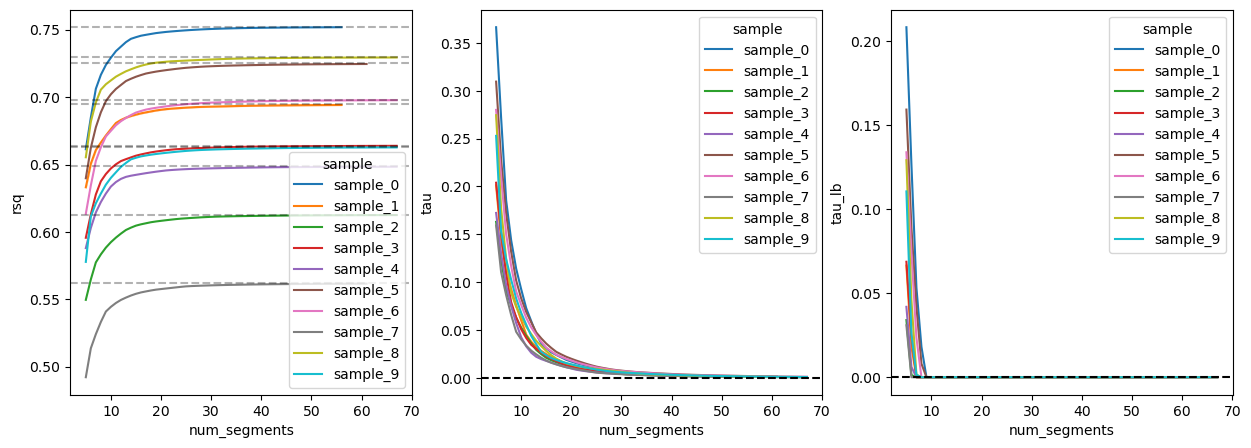

In [134]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
sns.lineplot(data = result, x = 'num_segments', y = 'rsq', hue = 'sample', ax = ax[0])
sns.lineplot(data = result, x = 'num_segments', y = 'tau', hue = 'sample', ax = ax[1])
sns.lineplot(data = result, x = 'num_segments', y = 'tau_lb', hue = 'sample', ax = ax[2])
for rsq_full in result.rsq_full.unique():
    ax[0].axhline(rsq_full, c = 'black', linestyle = '--', alpha = .3)
ax[1].axhline(0, c = 'black', linestyle = '--')
ax[2].axhline(0, c = 'black', linestyle = '--')
plt.show()

# Unseen Pairs

# Performance on testing dataset (maybe including unseen pairs)